In [1]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import matplotlib.pyplot as plt


In [2]:
class PaintableWallDataset(Dataset):
    def __init__(self, img_dir, mask_dir):
        self.img_dir = img_dir
        self.mask_dir = mask_dir

        # Keep only images that have corresponding masks
        self.imgs = []
        for f in sorted(os.listdir(img_dir)):
            if f.endswith(".jpg"):
                mask_name = f.replace(".jpg", ".png")
                if os.path.exists(os.path.join(mask_dir, mask_name)):
                    self.imgs.append(f)

        self.transform = T.Compose([
            T.Resize((128, 128)),   # low-spec safe
            T.ToTensor()
        ])

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_name = self.imgs[idx]

        # Load image
        img = Image.open(os.path.join(self.img_dir, img_name)).convert("RGB")
        img = self.transform(img)

        # Load ADE20K mask
        mask_name = img_name.replace(".jpg", ".png")
        mask = Image.open(os.path.join(self.mask_dir, mask_name))
        mask = mask.resize((128, 128), Image.NEAREST)
        mask = np.array(mask)

        # ADE20K: wall = class id 1
        mask = (mask == 1).astype(np.uint8)
        mask = torch.from_numpy(mask).long()

        return img, mask


Train samples: 275
Val samples: 275


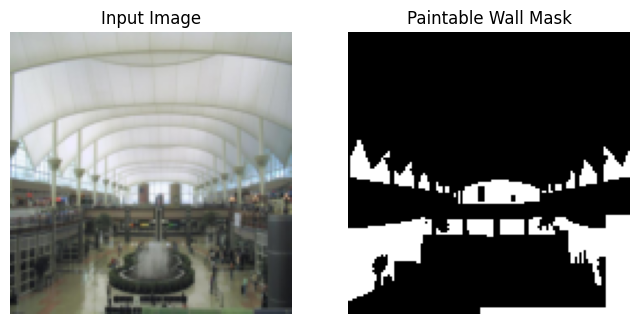

Mask values: tensor([0, 1])


In [3]:
train_ds = PaintableWallDataset(
    r"C:\Users\Gowri Shankar\Downloads\Kambaa\ADE20Ksmall\images\training",
    r"C:\Users\Gowri Shankar\Downloads\Kambaa\ADE20Ksmall\annotations\training"
)

val_ds = PaintableWallDataset(
    r"C:\Users\Gowri Shankar\Downloads\Kambaa\ADE20Ksmall\images\validation",
    r"C:\Users\Gowri Shankar\Downloads\Kambaa\ADE20Ksmall\annotations\validation"
)

train_loader = DataLoader(train_ds, batch_size=1, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=1, shuffle=False)

print("Train samples:", len(train_ds))
print("Val samples:", len(val_ds))

# Visual check
img, mask = train_ds[0]

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(img.permute(1,2,0))
plt.title("Input Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(mask, cmap="gray")
plt.title("Paintable Wall Mask")
plt.axis("off")
plt.show()

print("Mask values:", torch.unique(mask))


In [6]:
from torchvision.models.segmentation import fcn_resnet50

device = "cuda" if torch.cuda.is_available() else "cpu"

model = fcn_resnet50(weights="DEFAULT")

# FCN ResNet50 output channels = 2048
model.classifier[4] = nn.Conv2d(512, 2, kernel_size=1)

# Freeze backbone
for param in model.backbone.parameters():
    param.requires_grad = False

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=1e-4)


In [ ]:
EPOCHS = 5

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0

    for imgs, masks in train_loader:
        imgs = imgs.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)["out"]
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    # ---------- VALIDATION ----------
    model.eval()
    correct_pixels = 0
    total_pixels = 0
    val_loss = 0

    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs = imgs.to(device)
            masks = masks.to(device)

            outputs = model(imgs)["out"]
            loss = criterion(outputs, masks)
            val_loss += loss.item()

            preds = outputs.argmax(1)
            correct_pixels += (preds == masks).sum().item()
            total_pixels += masks.numel()

    val_loss /= len(val_loader)
    pixel_acc = correct_pixels / total_pixels

    print(f"""
Epoch {epoch+1}/{EPOCHS}
-----------------------
Train Loss : {train_loss:.4f}
Val Loss   : {val_loss:.4f}
Pixel Acc  : {pixel_acc*100:.2f}%
""")
    



Epoch 1/5
-----------------------
Train Loss : 0.5798
Val Loss   : 0.7990
Pixel Acc  : 73.94%


Epoch 2/5
-----------------------
Train Loss : 0.5343
Val Loss   : 1.7923
Pixel Acc  : 72.59%


Epoch 3/5
-----------------------
Train Loss : 0.5075
Val Loss   : 1.6426
Pixel Acc  : 70.75%


Epoch 4/5
-----------------------
Train Loss : 0.4810
Val Loss   : 4.5166
Pixel Acc  : 53.01%


Epoch 5/5
-----------------------
Train Loss : 0.4596
Val Loss   : 1.0153
Pixel Acc  : 73.46%



Using device: cpu
Train samples: 275
Val samples: 275


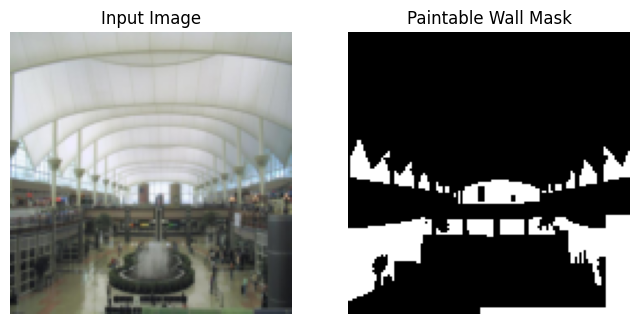

Unique mask values: tensor([0, 1])
Epoch 1/15
Train Loss: 0.5927 | Val Loss: 1.0614 | Pixel Acc: 49.83%

Epoch 2/15
Train Loss: 0.5617 | Val Loss: 2.5811 | Pixel Acc: 48.92%

Epoch 3/15
Train Loss: 0.5536 | Val Loss: 1.1133 | Pixel Acc: 60.94%

Epoch 4/15
Train Loss: 0.5424 | Val Loss: 3.3908 | Pixel Acc: 48.64%

Epoch 5/15
Train Loss: 0.5342 | Val Loss: 2.3513 | Pixel Acc: 52.27%

Epoch 6/15
Train Loss: 0.5317 | Val Loss: 0.8052 | Pixel Acc: 71.42%

Epoch 7/15
Train Loss: 0.5296 | Val Loss: 0.8909 | Pixel Acc: 72.82%

Epoch 8/15
Train Loss: 0.5183 | Val Loss: 1.2807 | Pixel Acc: 70.07%

Epoch 9/15
Train Loss: 0.5140 | Val Loss: 1.9537 | Pixel Acc: 75.53%

Epoch 10/15
Train Loss: 0.5180 | Val Loss: 0.7992 | Pixel Acc: 57.30%

Epoch 11/15
Train Loss: 0.5176 | Val Loss: 1.6914 | Pixel Acc: 70.90%

Epoch 12/15
Train Loss: 0.5127 | Val Loss: 0.8347 | Pixel Acc: 59.33%

Epoch 13/15
Train Loss: 0.5102 | Val Loss: 0.6915 | Pixel Acc: 60.88%

Epoch 14/15
Train Loss: 0.5013 | Val Loss: 0.7199 |

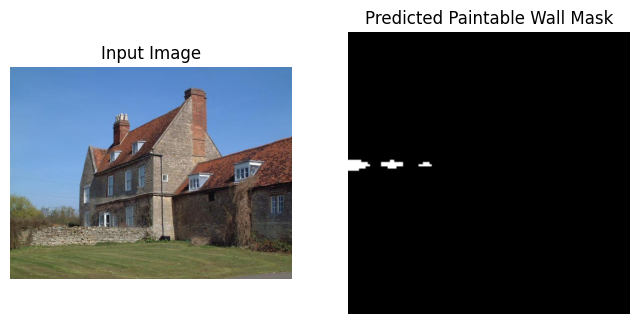

In [19]:
# ------------------------------
# 1️⃣ IMPORTS
# ------------------------------
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import matplotlib.pyplot as plt
from torchvision.models.segmentation import fcn_resnet50

# ------------------------------
# 2️⃣ DEVICE
# ------------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# ------------------------------
# 3️⃣ DATASET CLASS
# ------------------------------
class PaintableWallDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform

        self.imgs = sorted([f for f in os.listdir(img_dir) if f.endswith(".jpg")])

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_name = self.imgs[idx]

        # Load image
        img_path = os.path.join(self.img_dir, img_name)
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)

        # Load mask
        mask_name = img_name.replace(".jpg", ".png")
        mask_path = os.path.join(self.mask_dir, mask_name)
        if not os.path.exists(mask_path):
            raise FileNotFoundError(f"Mask not found: {mask_path}")

        mask = Image.open(mask_path).resize((128,128), Image.NEAREST)
        mask_np = np.array(mask)

        # Wall = class id 1
        wall_mask = (mask_np == 1).astype(np.uint8)
        mask = torch.tensor(wall_mask, dtype=torch.long)

        return img, mask

# ------------------------------
# 4️⃣ TRANSFORMS & DATALOADERS
# ------------------------------
train_transform = T.Compose([
    T.Resize((128,128)),
    T.ToTensor()
])

# Update paths to your ADE20K small subset
train_ds = PaintableWallDataset(
    img_dir=r"C:\Users\Gowri Shankar\Downloads\Kambaa\ADE20Ksmall\images\training",
    mask_dir=r"C:\Users\Gowri Shankar\Downloads\Kambaa\ADE20Ksmall\annotations\training",
    transform=train_transform
)

val_ds = PaintableWallDataset(
    img_dir=r"C:\Users\Gowri Shankar\Downloads\Kambaa\ADE20Ksmall\images\validation",
    mask_dir=r"C:\Users\Gowri Shankar\Downloads\Kambaa\ADE20Ksmall\annotations\validation",
    transform=train_transform
)

train_loader = DataLoader(train_ds, batch_size=2, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=2, shuffle=False)

print("Train samples:", len(train_ds))
print("Val samples:", len(val_ds))

# ------------------------------
# 5️⃣ VISUALIZE ONE SAMPLE
# ------------------------------
img, mask = train_ds[0]
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.imshow(img.permute(1,2,0))
plt.title("Input Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(mask, cmap="gray")
plt.title("Paintable Wall Mask")
plt.axis("off")
plt.show()

print("Unique mask values:", torch.unique(mask))

# ------------------------------
# 6️⃣ MODEL
# ------------------------------
model = fcn_resnet50(weights="DEFAULT")
model.classifier[4] = nn.Conv2d(512, 2, kernel_size=1)  # binary: wall vs non-wall

# Freeze backbone for low-spec
for param in model.backbone.parameters():
    param.requires_grad = False

model = model.to(device)

criterion = nn.CrossEntropyLoss(weight=torch.tensor([1.0, 3.0]).to(device))

optimizer = torch.optim.Adam(model.classifier.parameters(), lr=5e-5)


# ------------------------------
# 7️⃣ TRAINING LOOP
# ------------------------------
EPOCHS = 15

for epoch in range(EPOCHS):
    # ---------- TRAIN ----------
    model.train()
    train_loss = 0
    for imgs, masks in train_loader:
        imgs, masks = imgs.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)["out"]
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    # ---------- VALIDATION ----------
    model.eval()
    val_loss = 0
    correct_pixels = 0
    total_pixels = 0

    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(device), masks.to(device)

            outputs = model(imgs)["out"]
            val_loss += criterion(outputs, masks).item()

            preds = outputs.argmax(1)
            correct_pixels += (preds == masks).sum().item()
            total_pixels += masks.numel()

    val_loss /= len(val_loader)
    pixel_acc = correct_pixels / total_pixels

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Pixel Acc: {pixel_acc*100:.2f}%\n")

# ------------------------------
# 8️⃣ PREDICTION ON A SINGLE IMAGE
# ------------------------------
test_img_path = r"C:\Users\Gowri Shankar\Downloads\Kambaa\ADE20Ksmall\images\validation\ADE_val_00000001.jpg"
img = Image.open(test_img_path).convert("RGB")
input_tensor = train_transform(img).unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    output = model(input_tensor)["out"]
    pred_mask = output.argmax(1).cpu().squeeze()

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Input Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(pred_mask, cmap="gray")
plt.title("Predicted Paintable Wall Mask")
plt.axis("off")
plt.show()


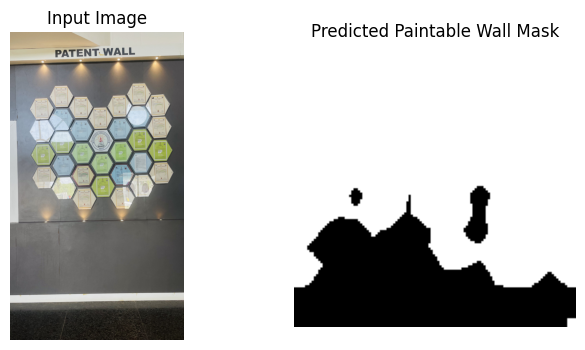

In [30]:
test_img_path = r"C:\Users\Gowri Shankar\Downloads\Kambaa\IMG_3750.jpeg"
img = Image.open(test_img_path).convert("RGB")
input_tensor = train_transform(img).unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    output = model(input_tensor)["out"]
    pred_mask = output.argmax(1).cpu().squeeze()

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Input Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(pred_mask, cmap="gray")
plt.title("Predicted Paintable Wall Mask")
plt.axis("off")
plt.show()


In [31]:
torch.save(model.state_dict(), "wall_segmentation_fcn.pth")


In [32]:
model.eval()

with torch.no_grad():
    output = model(input_tensor)["out"]
    pred_mask = output.argmax(1).cpu().numpy()[0]  # shape: HxW


In [33]:
import cv2
import numpy as np

# Convert to uint8
wall_mask = (pred_mask == 1).astype(np.uint8) * 255

# Kernel for morphology
kernel = np.ones((7,7), np.uint8)

# 1. Close gaps inside wall
wall_mask = cv2.morphologyEx(wall_mask, cv2.MORPH_CLOSE, kernel)

# 2. Remove small noise
wall_mask = cv2.morphologyEx(wall_mask, cv2.MORPH_OPEN, kernel)

# 3. Fill holes
contours, _ = cv2.findContours(wall_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
clean_mask = np.zeros_like(wall_mask)
cv2.drawContours(clean_mask, contours, -1, 255, thickness=cv2.FILLED)


array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [  0,   0,   0, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255]], dtype=uint8)

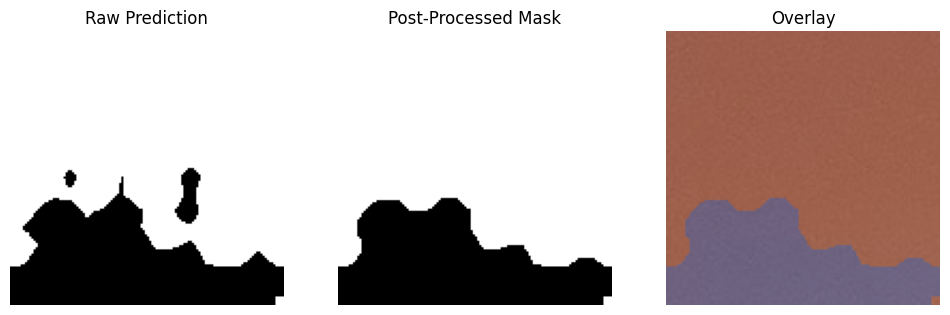

In [34]:
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.title("Raw Prediction")
plt.imshow(pred_mask, cmap="gray")
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Post-Processed Mask")
plt.imshow(clean_mask, cmap="gray")
plt.axis("off")

plt.subplot(1,3,3)
plt.title("Overlay")
plt.imshow(img)
plt.imshow(clean_mask, cmap="jet", alpha=0.4)
plt.axis("off")

plt.show()


In [35]:
paintable_pixels = np.sum(clean_mask == 255)
total_pixels = clean_mask.size
paintable_ratio = paintable_pixels / total_pixels


In [36]:
wall_width_ft = 12
wall_height_ft = 9
wall_area_sqft = wall_width_ft * wall_height_ft


In [37]:
paintable_area_sqft = paintable_ratio * wall_area_sqft
paintable_area_sqm = paintable_area_sqft * 0.092903


In [38]:
print(f"Paintable Area: {paintable_area_sqft:.2f} sq.ft")
print(f"Paintable Area: {paintable_area_sqm:.2f} sq.m")


Paintable Area: 80.77 sq.ft
Paintable Area: 7.50 sq.m
